# Experiment 2: Bayesian vs. PES (Delta) Learning Rule

Basic experiment to observe any noteable differences between the Bayesian learning rule and PES learning rule. Mathematically, the key difference is that the Bayesian rule learns based on the error signal and relative variance of each weight, whereas the PES rule applies a consistent learning rate to the error signal.


In [22]:
import nengo
from nengo.processes import WhiteSignal
import numpy as np
import matplotlib.pyplot as plt
from learning_rules import Bayesian

### Experiment set-up

A function that takes in two population sizes, a function to compute between populations, a time duration, and parameters for the PES and Bayesian learning rules. Outputs results comparing the two learning rules' performances computing different functions.


In [ ]:
def pes_vs_bayesian(pes_learning_rate, bayesian_priors, func, T, n_a, n_b):
    """
    Compares PES and Bayesian online learning rules for a specified function between two neuron ensembles.
    Plots the results.
    """

    prior_mean, prior_variance = bayesian_priors

    with nengo.Network(label="PES vs. Bayesian") as model:
        # White signal input stim to be transformed by func
        stim = nengo.Node(WhiteSignal(T, high=1), size_out=1)

        # Target function applied to stim
        transformed_stim = nengo.Node(lambda t, x: func(x), size_in=1, size_out=1)
        nengo.Connection(stim, transformed_stim)

        pre = nengo.Ensemble(n_a, dimensions=1)
        post_pes = nengo.Ensemble(n_b, dimensions=1, radius=2.0)
        post_bayesian = nengo.Ensemble(n_b, dimensions=1, radius=2.0)

        nengo.Connection(stim, pre)

        # PES learning between ensembles, targets decoders
        pes_conn = nengo.Connection(
            pre, post_pes, function=lambda x: [0], learning_rule_type=nengo.PES(pes_learning_rate)
        )

        # PES error = actual - target
        error_pes = nengo.Ensemble(n_b, dimensions=1)
        nengo.Connection(post_pes, error_pes)
        nengo.Connection(transformed_stim, error_pes, transform=-1)
        nengo.Connection(error_pes, pes_conn.learning_rule)

        # Bayesian learning between ensembles, targets weights
        bayesian_conn = nengo.Connection(
            pre,
            post_bayesian,
            function=lambda x: [0],
            solver=nengo.solvers.NoSolver(weights=True),
            learning_rule_type=Bayesian(prior_mean, prior_variance),
        )

        # Bayesian error = target - actual
        error_bayesian = nengo.Ensemble(n_b, dimensions=1)
        nengo.Connection(transformed_stim, error_bayesian)
        nengo.Connection(post_bayesian, error_bayesian, transform=-1)
        nengo.Connection(error_bayesian, bayesian_conn.learning_rule)

        # Probes
        stim_probe = nengo.Probe(stim)
        post_pes_probe = nengo.Probe(post_pes, synapse=0.01)
        post_bayesian_probe = nengo.Probe(post_bayesian, synapse=0.01)

    with nengo.Simulator(model) as sim:
        sim.run(T)

    t = sim.trange()
    stim_data = sim.data[stim_probe]
    post_pes_data = sim.data[post_pes_probe]
    post_bayesian_data = sim.data[post_bayesian_probe]

    # Ideal output
    ideal_output = np.array([func(x) for x in stim_data])

    # RMSE
    rmse_pes = np.sqrt(np.mean((post_pes_data - ideal_output) ** 2, axis=1))
    rmse_bayesian = np.sqrt(np.mean((post_bayesian_data - ideal_output) ** 2, axis=1))

    # Show stim transformed by f
    plt.figure(figsize=(12, 5))
    plt.title("Stim vs. Transformed Stim")
    plt.plot(t, ideal_output, label="Ideal output")
    plt.plot(t, stim_data, label="Stim", color="blue", alpha=0.3)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()

    # PES results
    plt.figure(figsize=(12, 6))
    plt.plot(t, ideal_output, label="Ideal output")
    plt.plot(t, post_pes_data, label=f"PES output")
    plt.xlabel("Time (s)")
    plt.title(f"PES Learning (LR={pes_learning_rate})")
    plt.legend()
    plt.show()

    # Bayesian results
    plt.figure(figsize=(12, 5))
    plt.plot(t, ideal_output, label="Ideal output")
    plt.plot(t, post_bayesian_data, label="Bayesian output")
    plt.xlabel("Time (s)")
    plt.title(f"Bayesian Learning ($\mu={np.mean(prior_mean):.2f}, \sigma^2={np.mean(prior_variance):.2f}$)")    
    plt.legend()
    plt.show()

    # RMSE
    plt.figure(figsize=(12, 4))
    plt.plot(t, rmse_pes, color="red", label="PES RMSE")
    plt.plot(t, rmse_bayesian, color="pink", label="Bayesian RMSE")
    plt.xlabel("Time (s)")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

### 1. Learn the identity function


Build finished in 0:00:01.                                                      
Simulation finished in 0:00:12.                                                 


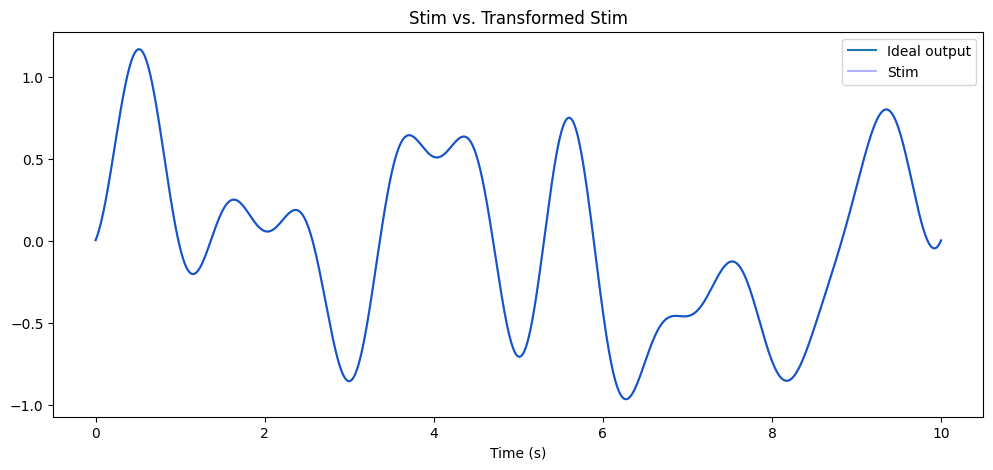

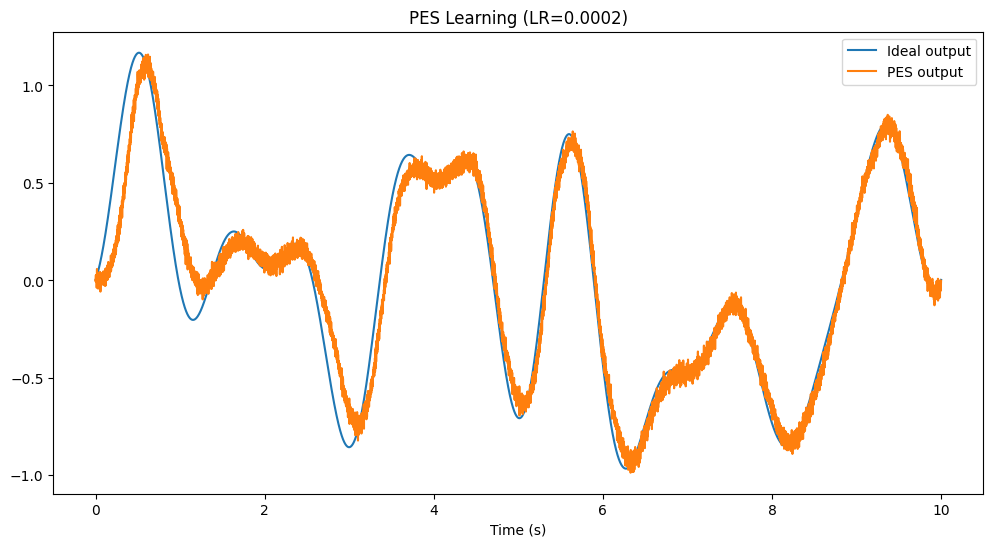

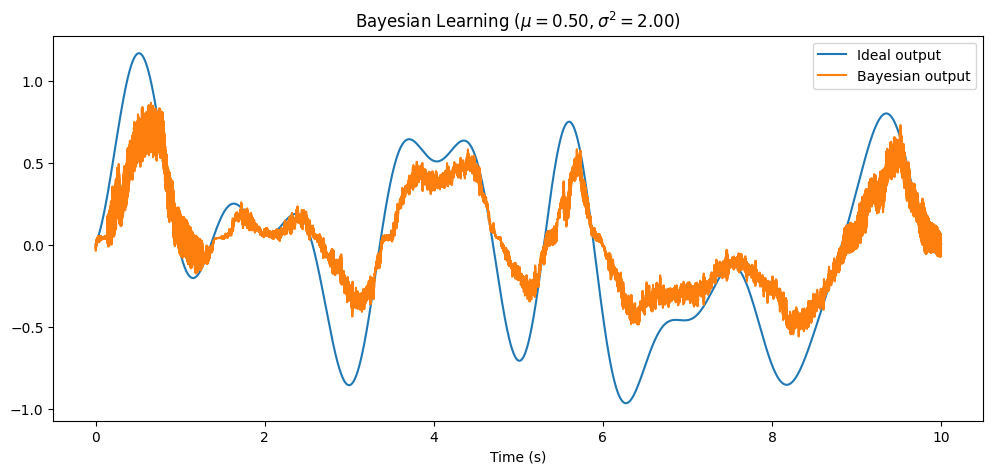

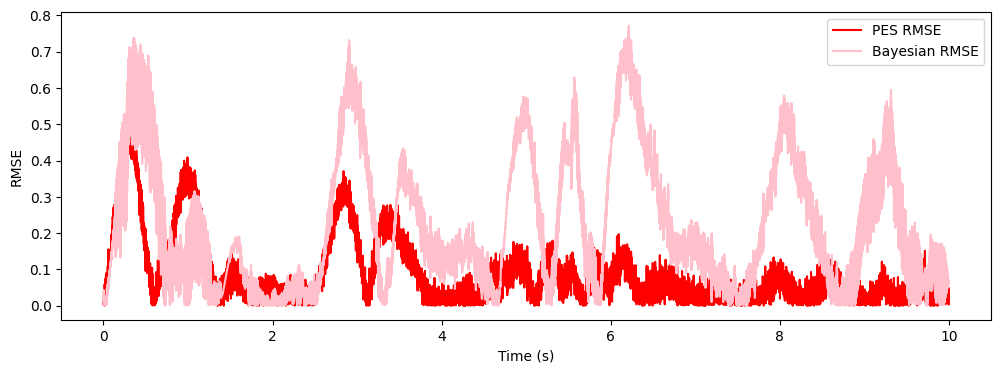

In [26]:
n_a, n_b = 100, 100

identity_function = lambda x: x

pes_vs_bayesian(
    pes_learning_rate=2e-4,
    bayesian_priors=(np.full((n_a, n_b), 0.5), np.full((n_a, n_b), 2.0)),
    func=identity_function,
    T=10,
    n_a=n_a,
    n_b=n_b
)

### 2. Learn a Sine Function


Build finished in 0:00:01.                                                      
Simulation finished in 0:00:18.                                                 


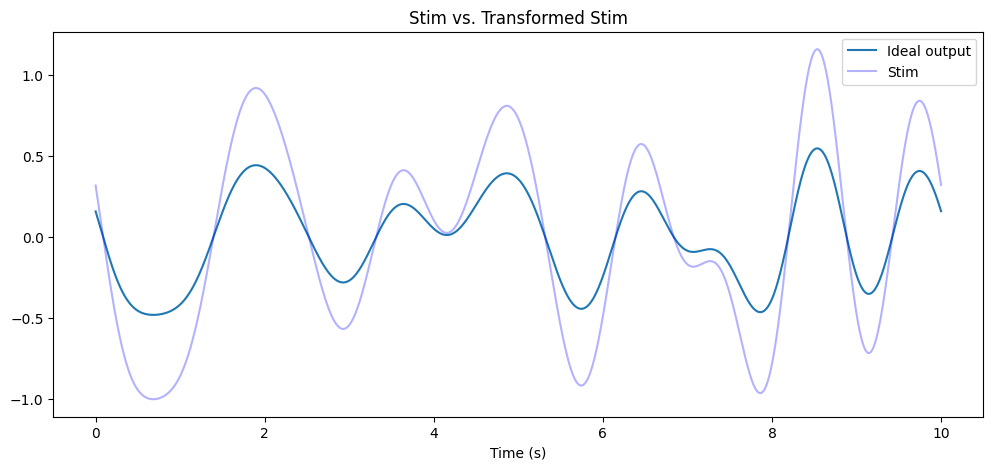

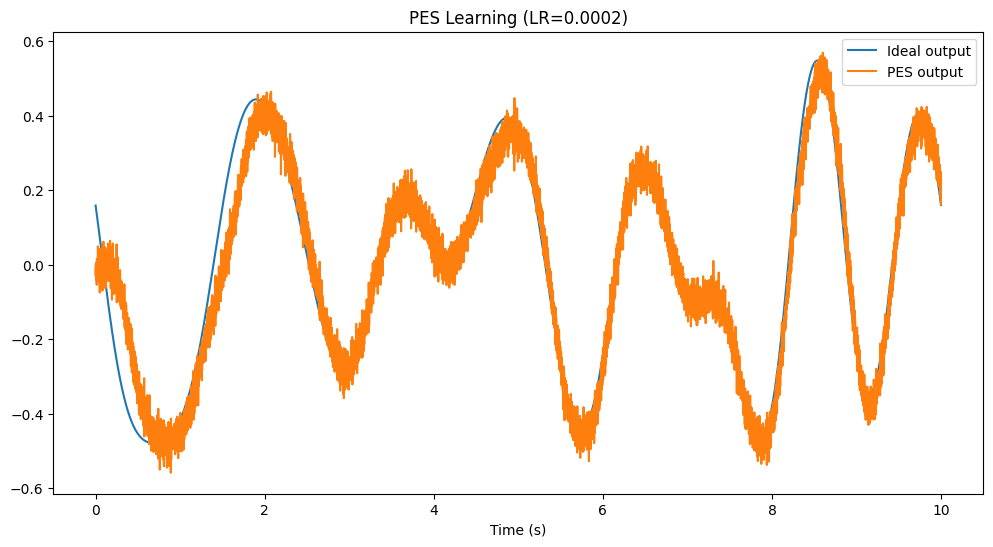

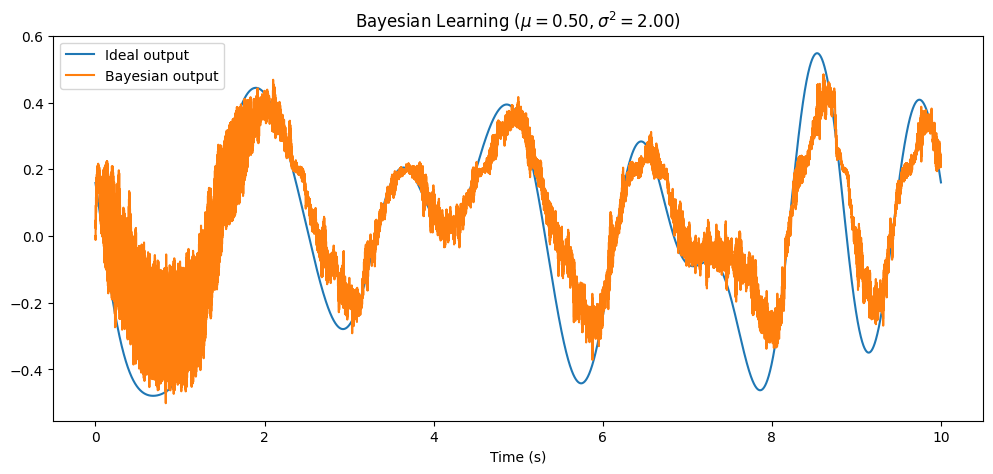

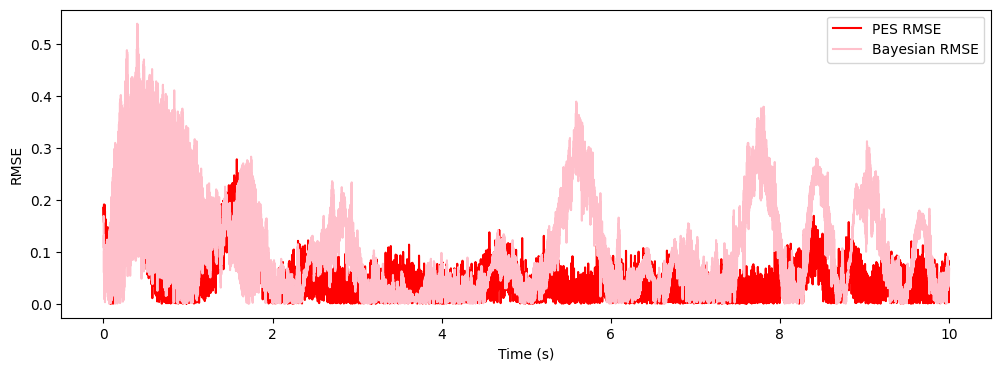

In [28]:
sinusoid = lambda x: np.sin(0.5*x)

pes_vs_bayesian(
    pes_learning_rate=2e-4,
    bayesian_priors=(np.full((n_a, n_b), 0.5), np.full((n_a, n_b), 2.0)),
    func=sinusoid,
    T=10,
    n_a=n_a,
    n_b=n_b
)

### 3. Learn a ramp function


Build finished in 0:00:01.                                                      
Simulation finished in 0:00:13.                                                 


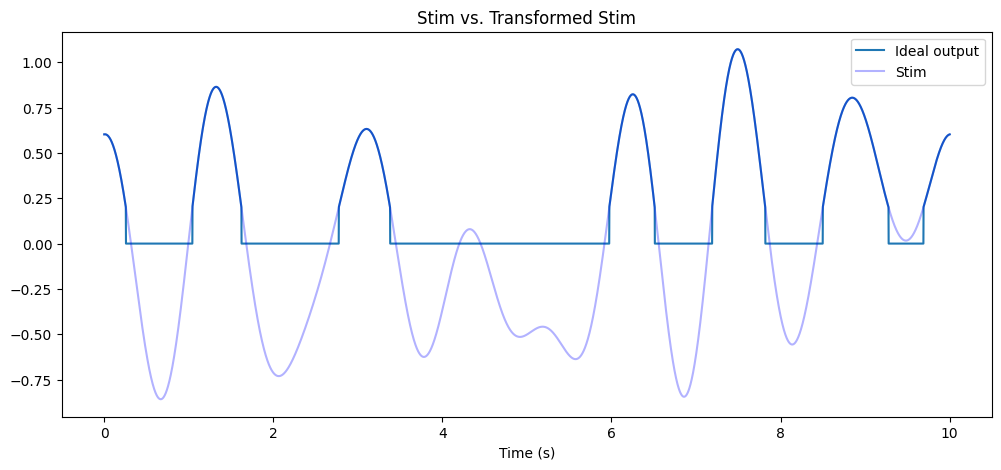

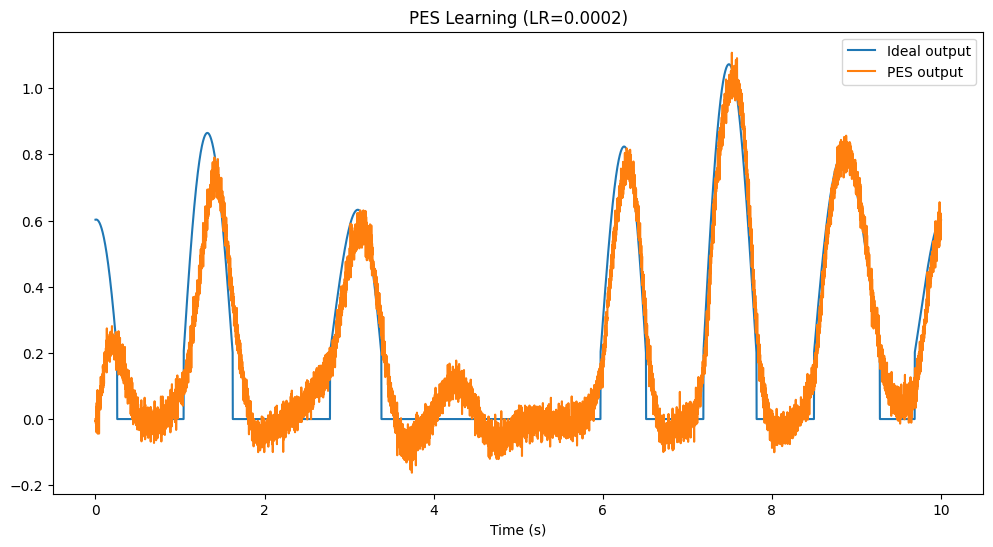

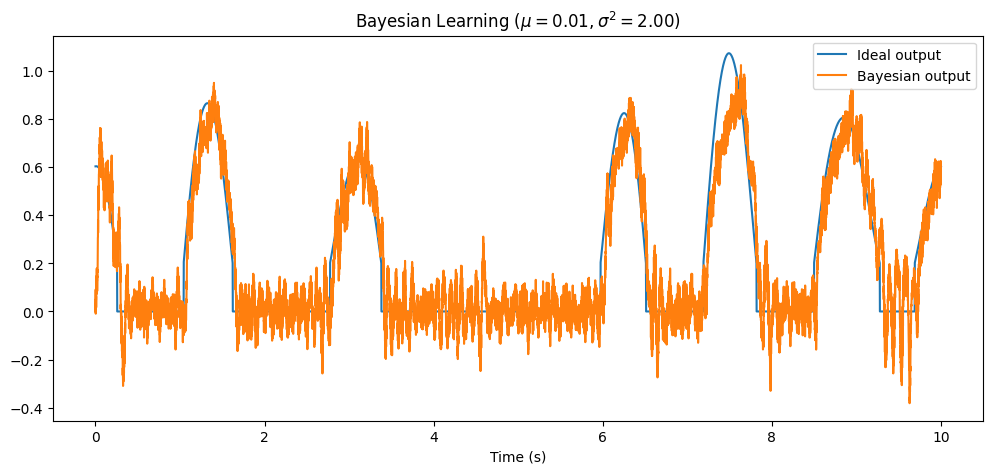

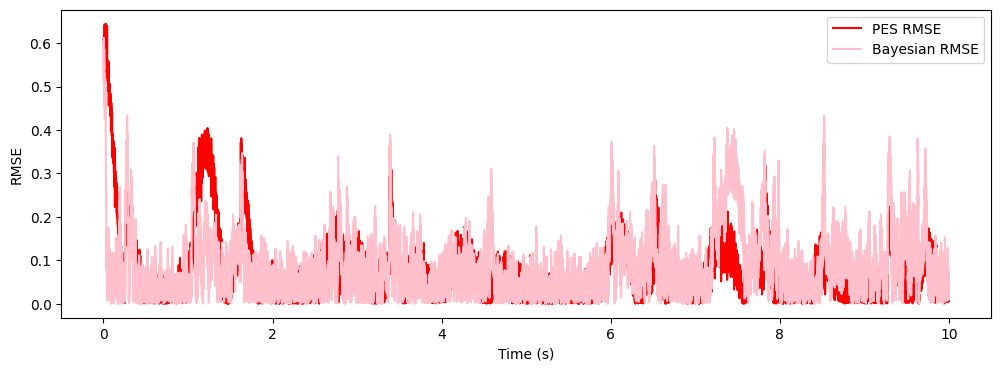

In [31]:
ramp = lambda x: np.where(x >= 0.2, x, 0)

pes_vs_bayesian(
    pes_learning_rate=2e-4,
    bayesian_priors=(np.full((n_a, n_b), 0.01), np.full((n_a, n_b), 2.0)),
    func=ramp,
    T=10,
    n_a=n_a,
    n_b=n_b
)

### Learn a quadratic function


Build finished in 0:00:01.                                                      
Simulation finished in 0:00:11.                                                 


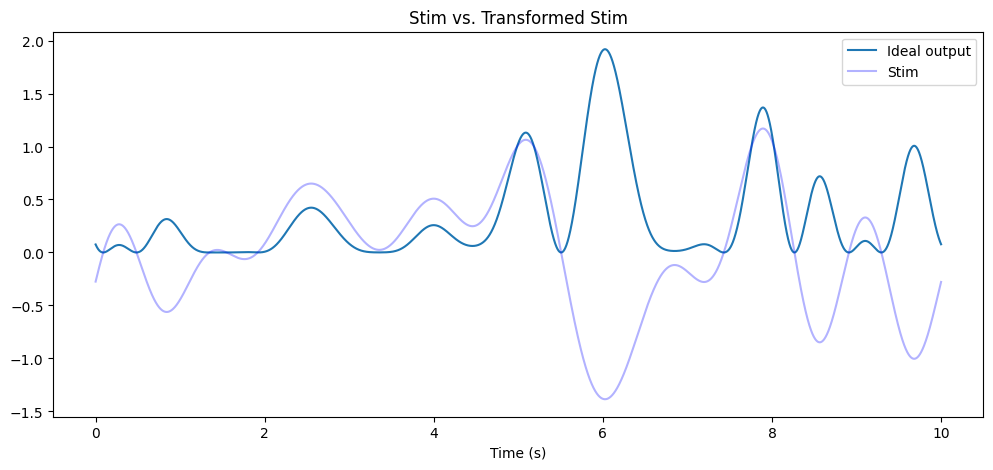

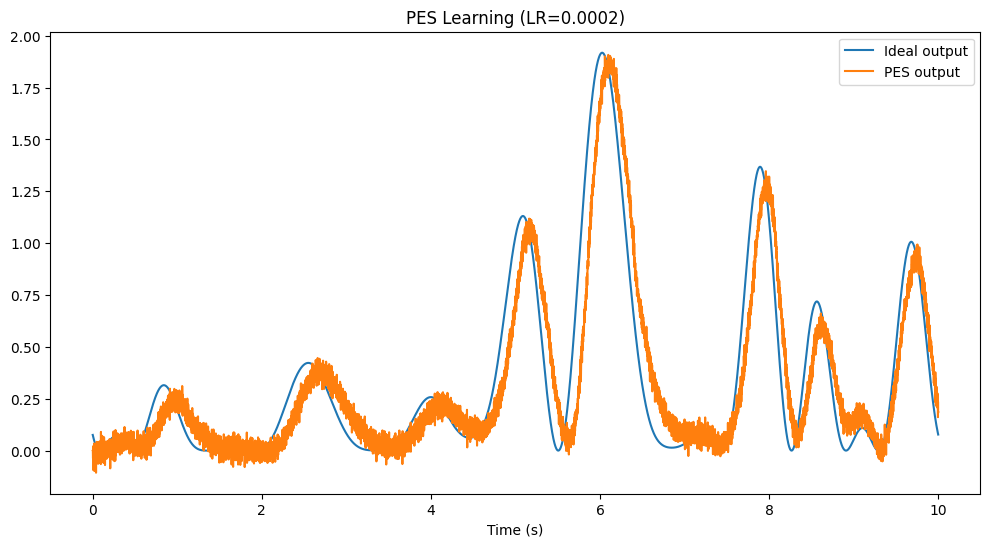

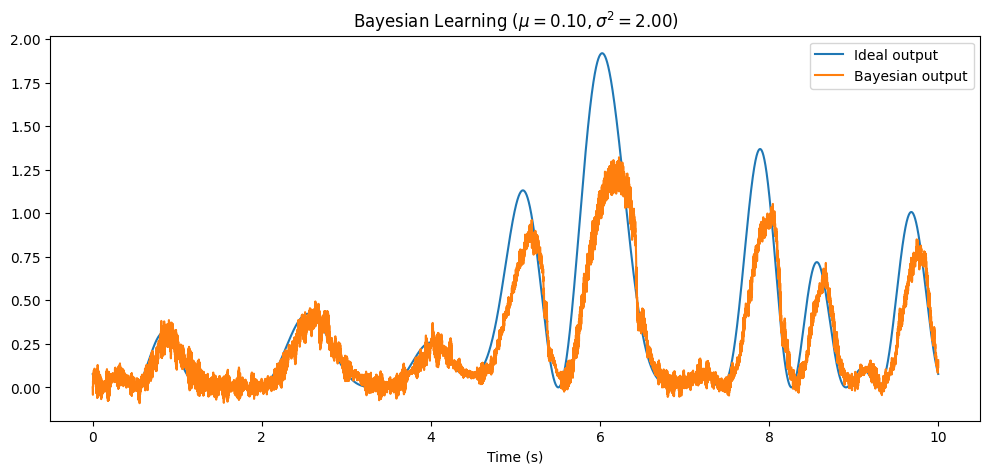

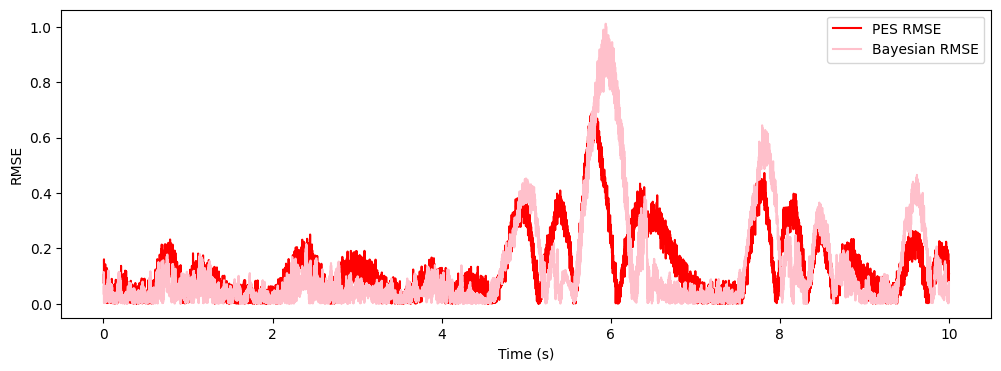

In [34]:
quadratic = lambda x: x**2

pes_vs_bayesian(
    pes_learning_rate=2e-4,
    bayesian_priors=(np.full((n_a, n_b), 0.1), np.full((n_a, n_b), 2.0)),
    func=quadratic,
    T=10,
    n_a=n_a,
    n_b=n_b
)